Notebook to generate semisynthetic CML data from a RADOLAN image and to reconstruct fields from this data using Random Mixing.

# Import

In [2]:
import os
import sys

fpth = os.path.abspath(os.path.join('..','RMWSPy', 'cml_example'))
sys.path.append(fpth)
fpth = os.path.abspath(os.path.join('..','RMWSPy', 'rmwspy'))
sys.path.append(fpth)

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import sparse

# copied from pycomlink to aviod dowloading conflicting libraries
from grid_intersection import get_grid_time_series_at_intersections
from grid_intersection import calc_sparse_intersect_weights_for_several_cmls
from grid_intersection import calc_intersect_weights

import datetime
from tqdm import tqdm
import yaml

import rain_data as cmlp
import RM_processing as rmp
from cml import *

import CRPS.CRPS as pscore

%load_ext autoreload
%autoreload 2

In [3]:
erlend_pth = os.path.abspath(os.path.join('..','..'))
sys.path.append(erlend_pth)
from RM_processing import create_blocks_from_lines
from RM_processing import generate_cmls_grid_intersects

from scipy.stats import norm
import gstools as gs
import os, shutil

# supress warnings from shapely
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import pickle

In [4]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as tkr
from matplotlib.ticker import FormatStrFormatter

# prepare semisynthetic CML data from rad image

In [5]:
# define options
grid_point_location = "lower_left"     # for RADOLAN the pixel information is stored in the lower left pixel
outname = "cml_rain_from_rad"          # output file name

In [6]:
# load and slice radar data, note that the coordinates has bee shifted in order to hide the CML coordinates 
ds_rad = xr.open_dataset("./data/ds_rad.nc")
ds_cml = xr.open_dataset("./data/ds_cml.nc")

In [7]:
# radar at one timestep
t = "2021-06-20T00:15"
ds_rad_t = ds_rad.sel(time=t) 

In [8]:
# Delay grids to allow dask to track them
lats = dask.delayed(ds_rad.latitudes.load())
lons = dask.delayed(ds_rad_t.longitudes.load())

intersec_weights_list = []
cml_id_list = []

for cml_id, cml in tqdm(ds_cml.groupby("cml_id")):
    cml_id_list.append(cml_id)
    intersec_weights_list.append(
        dask.delayed(sparse.COO.from_numpy)(
            dask.delayed(calc_intersect_weights)(
                # dask.delayed(calc_intersect_weights)(
                x1_line=cml.site_a_longitude,
                y1_line=cml.site_a_latitude,
                x2_line=cml.site_b_longitude,
                y2_line=cml.site_b_latitude,
                x_grid=lons,  
                y_grid=lats,  
                grid_point_location=grid_point_location,
            )
        )
    )

100%|█| 430/430 [00:


In [9]:
intersec_weights_list = dask.compute(*intersec_weights_list)

# create mask with info whether a cml is on the rad grid
covered_by_rad_grid = []
for weight in tqdm(intersec_weights_list):
    if weight.sum() == 0:
        covered_by_rad_grid.append(False)
    elif weight.sum() > 0:
        covered_by_rad_grid.append(True)

da_intersec_weights_list = []
for cml_id, intersec_weights in zip(cml_id_list, intersec_weights_list):
    coords = ds_rad_t.coords
    coords["cml_id"] = cml_id
    da_intersec_weights_list.append(
        xr.DataArray(
            dims=("y", "x"),  
            coords=coords,
            data=intersec_weights,
        )
    )

da_intersec_weights = xr.concat(da_intersec_weights_list, dim="cml_id")


100%|█| 430/430 [00:


In [10]:
# for time coordinates: 
cmls = []
for time in ds_rad.time.values.copy():
    # create new dataset for path averages
    ds_gridded_along_cml = xr.Dataset(
        coords={
            "time": time,
            "cml_id": da_intersec_weights.cml_id,
        },
    )
    
    # create path averages
    temp_list = []
    temp = dask.array.tensordot(
        ds_rad.sel(time = time).rainfall_amount.data, da_intersec_weights.data, axes=[[0, 1], [1, 2]]
    )
    ds_gridded_along_cml["R"] = ["cml_id"], temp.compute()    
    
    # Add CML coordinates (adding one dataset coordinate adds all the others)
    ds_gridded_along_cml.coords["site_a_latitude"] = ds_cml.site_a_latitude
    # add info whether link is in the area that is covered by the gridded data
    ds_gridded_along_cml["covered_by_rad_grid"] = ("cml_id", covered_by_rad_grid)

    # Erlend: Changed this line to avoid error
    ds_gridded_along_cml["covered_by_rad_reach"] = (
        "cml_id",
        (~ds_gridded_along_cml.R.isnull() & ds_gridded_along_cml.covered_by_rad_grid).values
    )
    
    cmls.append(ds_gridded_along_cml)
ds_gridded_along_cml = xr.concat(cmls, dim = 'time')

# dask seem to sett all time to last timestep? this fixes that. 
ds_gridded_along_cml['time'] = ds_rad.time

In [11]:
# erlend: added some lines to overwrite existing netcdf
if outname is not None:
    file = "./data/%s.nc"%outname
    ds_gridded_along_cml.to_netcdf(
        file + '_', encoding={"R": {"zlib": True}}
    )
    shutil.copy(file+'_', file) #overwrite existing
    os.remove(file+'_')

# Use CML data in RM algorithm
Here I use the CML data in all steps. CML midpoints are used for the estimation of the spatial model, the transformation function, and (optional, see flag `linear_constraints`) as linear constraints. CML paths are still considered at the end as nonlinear constraints.

**Note that I remove several CMLs.** The reason is that it is not possible (singular matrix) to estimate the spatial model with observations on the same grid point. I remove them completely now, though it would be possible to use them as nonlinear constraints still.

In [129]:
# define options
lin_constraints = False             # whether linear constraints should be considered
nonlin_constraints = True           # whether nonlinear constraints should be considered
nfields = 4                         # number of ensemble members
maskR = None                        # special functionality with masking, should always be None here
outfolder = "../../data/fields/"    # path to output folder

In [130]:
def set_spatial_coordinates(ds_cml):

    # coords
    ds_cml["lat_center"] = (ds_cml.site_a_latitude + ds_cml.site_b_latitude) / 2
    ds_cml["lon_center"] = (ds_cml.site_a_longitude + ds_cml.site_b_longitude) / 2

    # project to radolan grid (mid-points and both poles)
    y, x = cmlp.projRADOLAN(ds_cml.lat_center.values, ds_cml.lon_center.values)
    y_a, x_a = cmlp.projRADOLAN(
        lat=ds_cml.site_a_latitude.values, lon=ds_cml.site_a_longitude.values
    )
    y_b, x_b = cmlp.projRADOLAN(
        lat=ds_cml.site_b_latitude.values, lon=ds_cml.site_b_longitude.values
    )

    ds_cml["y"] = ("cml_id", y)
    ds_cml["x"] = ("cml_id", x)
    ds_cml["y_a"] = ("cml_id", y_a)
    ds_cml["x_a"] = ("cml_id", x_a)
    ds_cml["y_b"] = ("cml_id", y_b)
    ds_cml["x_b"] = ("cml_id", x_b)

    ds_cml = ds_cml.set_coords(
        ("lat_center", "lon_center", "y", "x", "y_a", "x_a", "y_b", "x_b")
    )

    return ds_cml

In [131]:
from pyproj import CRS
from pyproj import Transformer

In [132]:
ds_cml = xr.open_dataset("./data/cml_rain_from_rad.nc",)
ds_cml = set_spatial_coordinates(ds_cml)
ds_rad = xr.open_dataset("./data/ds_rad.nc")


In [133]:
ds_rad = xr.open_dataset("./data/ds_rad.nc")


In [134]:

# Then transform radar grid to radolan
crs = CRS('EPSG:4326')  # WGS84 output reference system 
crs_source = CRS('EPSG:25832') # Europe (used for shifted coords)
proj = Transformer.from_crs(crs_source, crs, always_xy=True)

# grid that follows longitudes
x_wgs = np.array([proj.transform(ds_rad.x.values[i]*1000, ds_rad.y.values[0]*1000) for i in range(ds_rad.x.size)])

# grid that follows latitudes
y_wgs = np.array([proj.transform(ds_rad.x.values[0]*1000, ds_rad.y.values[i]*1000) for i in range(ds_rad.y.size)])

_, x = cmlp.projRADOLAN(x_wgs[:, 1], x_wgs[:, 0])
y, _ = cmlp.projRADOLAN(y_wgs[:, 1], y_wgs[:, 0])

ds_rad['x'] = ('x', x)
ds_rad['y'] = ('y', y)


In [135]:
# rad for one time step
ds_rad_t = ds_rad.sel(time=t)

In [136]:
# domain
ymin = ds_rad_t.y.min().values # bruk heller hele lat lon 
xmin = ds_rad_t.x.min().values
ymax = ds_rad_t.y.max().values
xmax = ds_rad_t.x.max().values

# domainsize defined by radolan image (ensure that y is first coordinate of rainfall amount)
domainsize = ds_rad_t.rainfall_amount.shape

# grid coords used for RM output (make sure to include last grid point by 
# adding a small number below the resolution of 1 km, e.g. 0.1)
ygrid=np.arange(ymin + 0.5, ymax - 0.5)
xgrid=np.arange(xmin + 0.5, xmax - 0.5)

In [137]:
# remove links outside grid
ds_cml = ds_cml.where(ds_cml.x_a > xgrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b > xgrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.x_a < xgrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b < xgrid[-1], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a > ygrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b > ygrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a < ygrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b < ygrid[-1], drop= True)

In [138]:
# shift towards origin
# Now these variables represent both the indice and length between them, they can also be represented in RM? 
ds_cml["y_a"] = (ds_cml.y_a - ymin).astype(int)
ds_cml["x_a"] = (ds_cml.x_a - xmin).astype(int)
ds_cml["y_b"] = (ds_cml.y_b - ymin).astype(int)
ds_cml["x_b"] = (ds_cml.x_b - xmin).astype(int)

# set midpoint
ds_cml["x"] = ((ds_cml.x_a + ds_cml.x_b)/2).astype(int)
ds_cml["y"] = ((ds_cml.y_a + ds_cml.y_b)/2).astype(int)

In [139]:
# adjust naming conventions
ds_cml = ds_cml.rename({"cml_id": "obs_id"})

In [140]:
# consider one time step only (in this case no time dim anyway)

# remove observations that fall on the same grid point
ds_cml = cmlp.label_combined_duplicates(ds_cml)
ds_cml = ds_cml.where(ds_cml.label_dupl, drop=True)

# remove some cmls that are duplicates
ds_cml['duplicate'] = np.logical_and( ds_cml.x_a == ds_cml.x_b, ds_cml.y_a == ds_cml.y_b)
ds_cml['duplicate'] = ds_cml['duplicate'] != 0 # 
ds_cml = ds_cml.where(ds_cml.duplicate == False, drop = True)
ds_cml_at_t = ds_cml.sel(time = t)


In [141]:
ds_cml.drop(['R', 'covered_by_rad_grid', 'covered_by_rad_reach', 'label_dupl', 
             'duplicate']).to_netcdf('/home/erlend/Downloads/geometry_gerany')

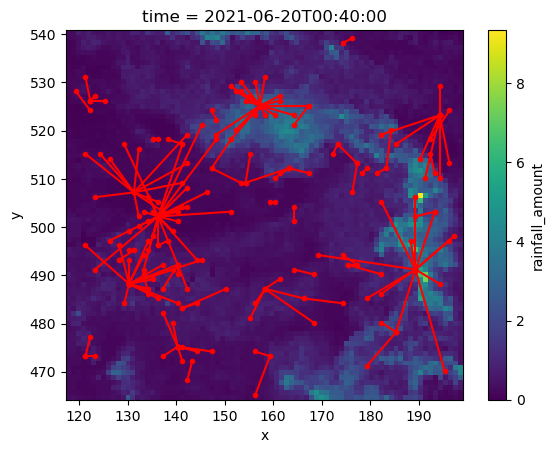

In [142]:
# plot the situation:
ds_rad.sel(time =  "2021-06-20T00:40").rainfall_amount.plot.imshow()

for device in ds_cml_at_t.obs_id:
    plt.plot([xgrid[device.x_a], xgrid[device.x_b]],[
            ygrid[device.y_a], ygrid[device.y_b]], '-r', marker='o', markersize =3)

# Plot 1: Rainfields

In [143]:
time_plot = "2021-06-20T00:40"
nfields = 20 # number of fields to generate and fields to sample from. 
N = 50 # number of samples from conditioned fields and real field 

synthetic_gridsize_yx = (ds_rad.y.size, ds_rad.x.size)
time_iterate = [ds_cml.sel(time = time_plot).time.values]
seed = 2
for time in time_iterate:
    seed += 1 
    # prepare data for timestep
    ds_cmls_copula = ds_cml.sel(time = time)
    ds_cmls_copula = cmlp.label_combined_duplicates(ds_cmls_copula)
    ds_cmls_copula = ds_cmls_copula.where(ds_cmls_copula.label_dupl, drop=True)
    ds_cmls_copula['duplicate_coords'] = ds_cmls_copula.x == ds_cmls_copula.y 
    ds_cmls_copula = ds_cmls_copula.where(ds_cmls_copula.duplicate_coords == False, drop=True)
    
    # Method 0: True midpoint
    # Calulate Copula model and marginal
    ds_points = generate_cmls_grid_intersects(     
        ds_cmls_copula.x.values,
        ds_cmls_copula.y.values,
        np.ones(ds_cmls_copula.x.size)*0.1, # small lengths is regarded as points
        np.array([ds_rad.sel(time = time).rainfall_amount.values])
    )
    ds_points = ds_points.rename({'x_mid': 'x', 'y_mid': 'y', 'cml_id': 'obs_id'})

    lin_yx = np.vstack((ds_points.y.values, ds_points.x.values)).T.astype(int)
    lin_prec = ds_points.values.ravel()
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)

    marginal_true_mid = rmp.calculate_marginal(lin_prec*10) 
    cmod = rmp.calculate_copula( 
        lin_yx,
        lin_prec*10,
        outputfile=None,
        covmods=["Exp"],
        ntries=6,
        nugget=0.001,
        p0 = marginal_true_mid['p0'], # remove p0

    )
    cmod_true_midpoint = cmod
    

        
    # Method 1: Midpoint
    # Calulate Copula model and marginal
    lin_yx = np.vstack((ds_cmls_copula.y.values, ds_cmls_copula.x.values)).T.astype(int)
    lin_prec = ds_cmls_copula.R.values
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
    
    # nonlinear cml data for conditioning
    cml_yx = np.vstack(
        (
            ds_cmls_copula.y_a.values,
            ds_cmls_copula.x_a.values,
            ds_cmls_copula.y_b.values,
            ds_cmls_copula.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_copula.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
    marginal_mid = rmp.calculate_marginal(lin_prec*10, cml_prec)    
    cmod = rmp.calculate_copula( 
        lin_yx,
        lin_prec*10,
        outputfile=None,
        covmods=["Exp"],
        ntries=5,
        nugget=0.001,
        p0 = marginal_mid['p0'],
    )    
    cmod_midpoint = cmod
    


    # Prepare data for method 2 dereg.
    # first create geometry and fit copula model
    pos_x, pos_y = create_blocks_from_lines(np.hstack([
        ds_cmls_copula.y_a.values.reshape(-1, 1),
        ds_cmls_copula.y_b.values.reshape(-1, 1),
        ds_cmls_copula.x_a.values.reshape(-1, 1),
        ds_cmls_copula.x_b.values.reshape(-1, 1),
        ]), disc =8)
    cml_yx_block = np.array([pos_y, pos_x]).transpose([1, 0, 2])
    lin_prec = ds_cmls_copula.R.values
    cml_yx_block, lin_prec = cmlp.filter_nans_a(cml_yx_block, lin_prec)
    cml_yx = np.vstack(
        (
            ds_cmls_copula.y_a.values, 
            ds_cmls_copula.x_a.values,
            ds_cmls_copula.y_b.values,
            ds_cmls_copula.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_copula.R.values
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec) 
    marginal_cd = rmp.calculate_marginal(lin_prec*10, cml_prec) 
    cmod = rmp.calculate_copula(
        cml_yx_block,
        lin_prec*10,
        outputfile=None,
        covmods=["Exp"],
        ntries=5,
        nugget=0,
        mode='block',
        maxrange = float(cmod_midpoint.split('p')[-1][1:-3]),
        p0 = marginal_cd['p0'] # used to censor zero rainfall
    )
    cmod_dereg = cmod
    
    
    

In [144]:
cmod_true_midpoint

'0.001 Nug(0.0) + 0.999 Exp(14.198)'

In [145]:
cmod_midpoint

'0.001 Nug(0.0) + 0.999 Exp(20.121)'

In [146]:
cmod_dereg

'0.000 Nug(0.0) + 1.000 Exp(13.165)'

In [147]:
synthetic_gridsize_yx = (ds_rad.y.size, ds_rad.x.size)
time_iterate = [ds_cml.sel(time = time_plot).time.values]
seed = 2
for time in time_iterate:
    seed += 1
    ds_cmls_cond = ds_cml.sel(time = time).copy()
    ds_cmls_cond = cmlp.label_combined_duplicates(ds_cmls_cond)
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.label_dupl, drop=True)
    ds_cmls_cond['duplicate_coords'] = ds_cmls_cond.x == ds_cmls_cond.y 
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.duplicate_coords == False, drop=True)
    cml_yx = np.vstack(
        (
            ds_cmls_cond.y_a.values,
            ds_cmls_cond.x_a.values,
            ds_cmls_cond.y_b.values,
            ds_cmls_cond.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_cond.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)    
    nonlin_integrals = rmp.nl_integrals(cml_yx)     
    
    # true CM
    my_CMLModel = CMLModel(cml_prec, marginal_true_mid, nonlin_integrals)
    CS = RMWS(
        my_CMLModel,
        domainsize=synthetic_gridsize_yx,
        covmod=cmod_true_midpoint,
        nFields=nfields,
        cp=None,
        cv=None,
        le_cp=None,
        le_cv=None,
        optmethod="circleopt",
        minObj=0.4,
        maxbadcount=30,
        maxiter=100,
        pyfftwmode=True,
        seed=seed,
        tstep="aaa",
    )
    CS()
    final_fields = rmp.backtransform(CS.finalFields, marginal_true_mid)    
    copula_true_midpoint = final_fields.copy()
    
    
    # CM
    cml_yx = np.vstack(
        (
            ds_cmls_cond.y_a.values,
            ds_cmls_cond.x_a.values,
            ds_cmls_cond.y_b.values,
            ds_cmls_cond.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_cond.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)    
    nonlin_integrals = rmp.nl_integrals(cml_yx) 
    my_CMLModel = CMLModel(cml_prec, marginal_mid, nonlin_integrals)
    CS = RMWS(
        my_CMLModel,
        domainsize=synthetic_gridsize_yx,
        covmod=cmod_midpoint,
        nFields=nfields,
        cp=None,
        cv=None,
        le_cp=None,
        le_cv=None,
        optmethod="circleopt",
        minObj=0.4,
        maxbadcount=30,
        maxiter=100,
        pyfftwmode=True,
        seed=seed,
        tstep="aaa",
    )
    CS()
    final_fields = rmp.backtransform(CS.finalFields, marginal_mid)    
    copula_midpoint = final_fields.copy()
    
    
    
    # CD
    cml_yx = np.vstack(
        (
            ds_cmls_cond.y_a.values,
            ds_cmls_cond.x_a.values,
            ds_cmls_cond.y_b.values,
            ds_cmls_cond.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_cond.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)    
    nonlin_integrals = rmp.nl_integrals(cml_yx) 
    my_CMLModel = CMLModel(cml_prec, marginal_cd, nonlin_integrals)    
    CS = RMWS(
        my_CMLModel,
        domainsize=synthetic_gridsize_yx,
        covmod=cmod_dereg,
        nFields=nfields,
        cp=None,
        cv=None,
        le_cp=None,
        le_cv=None,
        optmethod="circleopt",
        minObj=0.4,
        maxbadcount=30,
        maxiter=100,
        pyfftwmode=True,
        seed=seed,
        tstep="aaa",
    )
    CS()
    final_fields = rmp.backtransform(CS.finalFields, marginal_cd)
    copula_dereg = final_fields.copy()
    
    # Truth: If we were to sample directly
    ranges_from_field = []
    true_field_t = ds_rad.sel(time = time).rainfall_amount.values    
    
    # use midpoint of links to sample points
    for _ in range(nfields):
        ds_points = generate_cmls_grid_intersects(
            np.random.randint(0, synthetic_gridsize_yx[1], size=N),
            np.random.randint(0, synthetic_gridsize_yx[0], size=N),
            np.ones(N)*0.01,
            true_field_t[np.newaxis, :, :],
        )
            
        # rename so we can work with existing function drop duplicate
        ds_points = ds_points.rename({'x_mid': 'x', 'y_mid': 'y', 'cml_id': 'obs_id'})
        ds_points = cmlp.label_combined_duplicates(ds_points)
        ds_points = ds_points.where(ds_points.label_dupl, drop=True)
        lin_yx = np.vstack((ds_points.y.values, ds_points.x.values)).T.astype(int)
        lin_prec = ds_points.values.ravel()
        lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
        
        marginal = rmp.calculate_marginal(lin_prec) 
        cmod = rmp.calculate_copula( 
            lin_yx,
            lin_prec,
            outputfile=None,
            covmods=["Exp"],
            ntries=6,
            nugget=0.001,
            p0 = marginal['p0'], # remove p0

        )
        ranges_from_field.append(float(cmod.split()[-1][4:-1]))
        
    copula_true = ranges_from_field
    
    


Generating random fields ...
...done in  5.086947 

---------------------
Realization number: 0

Calculating final fields...
 [0.39723667]
 Defined minimum objective function value reached!
...done in  2.001285 

---------------------
Realization number: 1

Calculating final fields...
 [0.44745388]
 Number of max model runs exceeded! --> Take current best solution!
...done in  3.965811 

---------------------
Realization number: 2

Calculating final fields...
 [0.39574792]
 Defined minimum objective function value reached!
...done in  3.035222 

---------------------
Realization number: 3

Calculating final fields...
 [0.39788877]
 Defined minimum objective function value reached!
...done in  2.237125 

---------------------
Realization number: 4

Calculating final fields...
 [0.39441854]
 Defined minimum objective function value reached!
...done in  1.259351 

---------------------
Realization number: 5

Calculating final fields...
 [0.39755664]
 Defined minimum objective function va

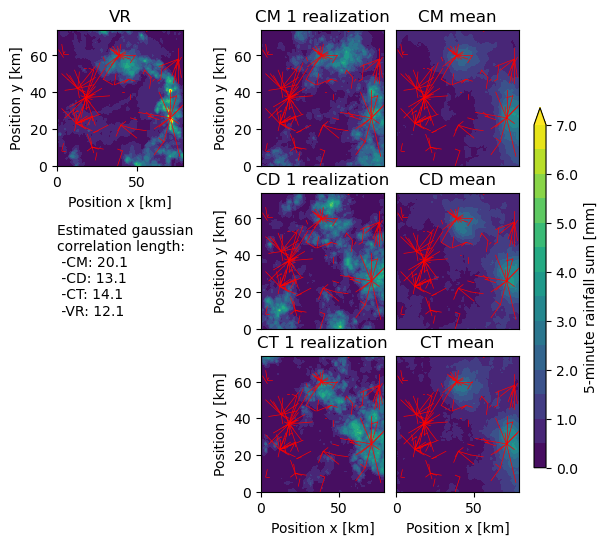

In [148]:
# which random fields to show, in general they vary much
isel = 2
n_levels = 15
fig = plt.figure(figsize =(6, 6))
cmap = plt.get_cmap('viridis').copy()


thresh = 0

linewidth_set= 0.5
gs_cml = GridSpec(3, 1, left=0.11, right=0.32)
min_val = 0
max_val = 7

levels = np.linspace(0, max_val, n_levels)
ax = []
ax.append(fig.add_subplot(gs_cml[0]))
ax.append(fig.add_subplot(gs_cml[1]))
gs2 = GridSpec(3, 2, wspace=0.1, left=0.45, right=0.88)
ax.append(fig.add_subplot(gs2[0]))
ax.append(fig.add_subplot(gs2[1]))
ax.append(fig.add_subplot(gs2[2]))
ax.append(fig.add_subplot(gs2[3]))
ax.append(fig.add_subplot(gs2[4]))
ax.append(fig.add_subplot(gs2[5]))


xgrid_plot = xgrid - xgrid.min()
ygrid_plot = ygrid - ygrid.min()

X, Y = np.meshgrid(xgrid_plot, ygrid_plot)

# plot the original field
im = ax[0].contourf(X, Y, 
                    ds_rad.sel(time =  time_plot).rainfall_amount.values, 
                    levels = levels, 
                    vmin=min_val, 
                    vmax=max_val,
                    cmap=cmap,
                    extend="max"    
                   )

for device in ds_cml.obs_id:
    ax[0].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-r', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[0].set_title('VR')
ax[0].set_xlabel('Position x [km]')
ax[0].set_ylabel('Position y [km]')

#fig.delaxes(ax[1, 0])
ax[1].text(0, 0.1, 'Estimated gaussian\ncorrelation length: \n -CM: ' + cmod_midpoint.split(
    'p')[-1][1:-3] + '\n -CD: ' + cmod_dereg.split('p')[-1][1:-3] + '\n -CT: ' + cmod_true_midpoint.split(
    'p')[-1][1:-3] + '\n -VR: ' + str(np.mean(
    copula_true))[0:4] , fontsize=10,)
ax[1].axis('off')

# colorbar
cbar_ax = fig.add_axes([0.905, 0.15, 0.02, 0.6]) # (left, bottom, width, height)
fig.colorbar(im, cax=cbar_ax, format=tkr.FormatStrFormatter('%.1f'))
cbar_ax.set_ylabel('5-minute rainfall sum [mm]')

#fig.colorbar(im,location='left', orientation="vertical", ax=cbar_ax)

# 1 realization
ax[2].contourf(
    X, 
    Y, 
    copula_midpoint[isel],  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    
)
#ax[2].contour(X, Y, mid_thresh, levels=[0.1], colors= 'green', linewidths= 1)

for device in ds_cml.obs_id:
    ax[2].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-r', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[2].set_title('CM 1 realization')
ax[2].set_xlabel('')
ax[2].set_ylabel('Position y [km]')


# mean
ax[3].contourf(
    X, 
    Y, 
    copula_midpoint.mean(axis = 0),  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    
)
for device in ds_cml.obs_id:
    ax[3].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[
            ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-r', markersize =linewidth_set, linewidth = linewidth_set)
ax[3].set_title('CM mean')




# plot 1 field dereg
ax[4].contourf(
    X, 
    Y, 
    copula_dereg[isel],  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    

)
for device in ds_cml.obs_id:
    ax[4].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-r', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[4].set_title('CD 1 realization')
ax[4].set_xlabel('')
ax[4].set_ylabel('Position y [km]')



# plot 1 field dereg
ax[5].contourf(
    X, 
    Y, 
    copula_dereg.mean(axis = 0),  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    
)
for device in ds_cml.obs_id:
    ax[5].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[
            ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-r', markersize =linewidth_set, linewidth = linewidth_set)
ax[5].set_title('CD mean')
ax[5].set_ylabel('')


# plot 1 field dereg
ax[6].contourf(
    X, 
    Y, 
    copula_true_midpoint[isel],  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    

)
for device in ds_cml.obs_id:
    ax[6].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-r', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[6].set_title('CT 1 realization')
ax[6].set_xlabel('')
ax[6].set_xlabel('Position x [km]')
ax[6].set_ylabel('Position y [km]')



# plot 1 field dereg
ax[7].contourf(
    X, 
    Y, 
    copula_true_midpoint.mean(axis = 0),  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    
)
for device in ds_cml.obs_id:
    ax[7].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[
            ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-r', markersize =linewidth_set, linewidth = linewidth_set)
ax[7].set_title('CT mean')
ax[7].set_xlabel('Position x [km]')
ax[7].set_ylabel('')




ax[2].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'x', 
    which='both'
)  

ax[3].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'both', 
    which='both'
)  

ax[4].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'x', 
    which='both'
) 

ax[5].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'both', 
    which='both'
)  


ax[7].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'y', 
    which='both'
)  
plt.savefig('/home/erlend/Downloads/result_RM_fields.png', format = 'png')

# Statistics for CM, CD and CT method for several timesteps

In [149]:
start =  "2021-06-19T22:30"
end = "2021-06-20T01:30"

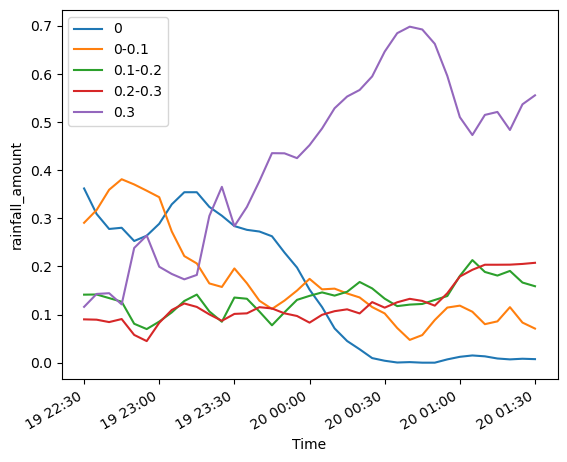

In [150]:
# radar percentages of different rainfall intensities: 
cmap = plt.get_cmap('viridis').copy()
(((ds_rad.sel(time = slice(start, end)).rainfall_amount == 0)).sum(axis = (1, 2)) /(75*80)).plot(label = '0')

(((ds_rad.sel(time = slice(start, end)).rainfall_amount > 0) & (ds_rad.sel(
    time = slice(start, end)).rainfall_amount < 0.1)).sum(axis = (1, 2)) /(75*80)).plot(label = '0-0.1')

(((ds_rad.sel(time = slice(start, end)).rainfall_amount >= 0.1) & (ds_rad.sel(
    time = slice(start, end)).rainfall_amount < 0.2)).sum(axis = (1, 2)) /(75*80)).plot(label = '0.1-0.2')

(((ds_rad.sel(time = slice(start, end)).rainfall_amount >= 0.2) & (ds_rad.sel(
    time = slice(start, end)).rainfall_amount < 0.3)).sum(axis = (1, 2)) /(75*80)).plot(label = '0.2-0.3')

(((ds_rad.sel(time = slice(start, end)).rainfall_amount >= 0.3)).sum(axis = (1, 2)) /(75*80)).plot(label = '0.3')

plt.legend()

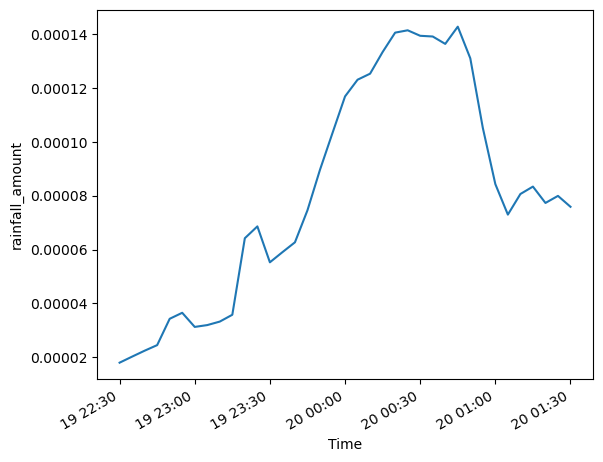

In [151]:
# radar sum rainfall
(ds_rad.sel(time = slice(start, end)).rainfall_amount.mean(axis = (1, 2)) /(75*80)).plot()

In [152]:
start =  "2021-06-20T00:00"
end = "2021-06-20T01:30"

In [153]:
nfields = 20 # number of fields to generate and fields to sample from. 
N = 70 # number of samples from conditioned fields and real field 

copula_midpoint = {'gaussian_range_unconditioned': [], 'gaussian_range_conditioned': [], 'field_conditioned': []}
copula_true_midpoint = {'gaussian_range_unconditioned': [], 'gaussian_range_conditioned': [], 'field_conditioned': []}
copula_dereg = {'gaussian_range_unconditioned': [], 'gaussian_range_conditioned': [], 'field_conditioned': []}
true_field = {'gaussian_range': [], 'gaussian_range_rain_only':[]}

time_list = []
synthetic_gridsize_yx = (ds_rad.y.size, ds_rad.x.size)

time_iterate = ds_cml.sel(time = slice(start, end)).time
# only one timestep, for debugging: 
#time_iterate = [ds_cml.sel(time = "2021-06-20T00:20").time.values]
seed = 0
for time in time_iterate:
    seed += 1 

    ds_cmls_copula_midpoint = ds_cml.sel(time = time) #.where(ds_cml.length  < 8, drop = True).copy()
    ds_cmls_copula_midpoint = cmlp.label_combined_duplicates(ds_cmls_copula_midpoint)
    ds_cmls_copula_midpoint = ds_cmls_copula_midpoint.where(ds_cmls_copula_midpoint.label_dupl, drop=True)
    ds_cmls_copula_midpoint['duplicate_coords'] = ds_cmls_copula_midpoint.x == ds_cmls_copula_midpoint.y # not alwas removed due to some roundoff i think
    ds_cmls_copula_midpoint = ds_cmls_copula_midpoint.where(ds_cmls_copula_midpoint.duplicate_coords == False, drop=True)
    
    
    
    # Method 0: True midpoint
    # Calulate Copula model and marginal
    ds_points = generate_cmls_grid_intersects(
        ds_cmls_copula_midpoint.x.values,
        ds_cmls_copula_midpoint.y.values,
        np.ones(ds_cmls_copula_midpoint.x.size)*0.1,
        np.array([ds_rad.sel(time = time).rainfall_amount.values])
    )
    ds_points = ds_points.rename({'x_mid': 'x', 'y_mid': 'y', 'cml_id': 'obs_id'})
    lin_yx = np.vstack((ds_points.y.values, ds_points.x.values)).T.astype(int)
    lin_prec = ds_points.values.ravel()
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)

    marginal_true_mid = rmp.calculate_marginal(lin_prec*10) 
    cmod = rmp.calculate_copula( 
        lin_yx,
        lin_prec*10,
        outputfile=None,
        covmods=["Exp"],
        ntries=6,
        nugget=0.001,
        p0 = marginal_true_mid['p0'], 
    )
    
    # store estimated range
    copula_true_midpoint['gaussian_range_unconditioned'].append(float(cmod.split()[-1][4:-1]))
    
    # Include all CMLs for conditioning
    ds_cmls_cond = ds_cml.sel(time = time).copy()
    ds_cmls_cond = cmlp.label_combined_duplicates(ds_cmls_cond)
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.label_dupl, drop=True)
    ds_cmls_cond['duplicate_coords'] = ds_cmls_cond.x == ds_cmls_cond.y 
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.duplicate_coords == False, drop=True)
    lin_yx = np.vstack((ds_cmls_cond.y.values, ds_cmls_cond.x.values)).T.astype(int)
    lin_prec = ds_cmls_cond.R.values 
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
    cml_yx = np.vstack(
        (
            ds_cmls_cond.y_a.values,
            ds_cmls_cond.x_a.values,
            ds_cmls_cond.y_b.values,
            ds_cmls_cond.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_cond.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)    
    nonlin_integrals = rmp.nl_integrals(cml_yx) 
    my_CMLModel = CMLModel(cml_prec, marginal_true_mid, nonlin_integrals)
    
    CS = RMWS(
        my_CMLModel,
        domainsize=synthetic_gridsize_yx,
        covmod=cmod,
        nFields=nfields,
        cp=None,
        cv=None,
        le_cp=None,
        le_cv=None,
        optmethod="circleopt",
        minObj=0.4,
        maxbadcount=30,
        maxiter=100,
        pyfftwmode=True,
        seed=seed,
        tstep="aaa",
    )
    CS()
    final_fields = rmp.backtransform(CS.finalFields, marginal_true_mid)
    ranges_from_field = [] # place points in field
    
    # investigate the spatial structure of the final fields
    for i in range(nfields):
        ds_points = generate_cmls_grid_intersects(
            np.random.randint(0, synthetic_gridsize_yx[1], size=N),
            np.random.randint(0, synthetic_gridsize_yx[0], size=N),
            np.ones(N)*0.1,
            np.array([final_fields[i, :, :]])
        )
            
        
        # rename so we can work with existing function drop duplicate
        ds_points = ds_points.rename({'x_mid': 'x', 'y_mid': 'y', 'cml_id': 'obs_id'})
        ds_points = cmlp.label_combined_duplicates(ds_points)
        ds_points = ds_points.where(ds_points.label_dupl, drop=True)
        
        # a and b is the same for points, thus we can just use that
        lin_yx = np.vstack((ds_points.y.values, ds_points.x.values)).T.astype(int)
        lin_prec = ds_points.values.ravel()
        lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
        
        # calculate marginal and p0.
        if (lin_prec > 0).sum()/lin_prec.size > 0.5:
            marginal = rmp.calculate_marginal(lin_prec) 
            cmod = rmp.calculate_copula( 
                lin_yx,
                lin_prec,
                outputfile=None,
                covmods=["Exp"],
                ntries=6,
                nugget=0.001,
                p0 = marginal['p0'], # remove p0

            )
            ranges_from_field.append(float(cmod.split()[-1][4:-1]))
        else:
            ranges_from_field.append(np.nan)

        
    # store statistics
    copula_true_midpoint['gaussian_range_conditioned'].append(np.array(ranges_from_field))
    copula_true_midpoint['field_conditioned'].append(final_fields)  
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    # Method 1: Copula midpoint, normal point initialization
    lin_yx = np.vstack((ds_cmls_copula_midpoint.y.values, ds_cmls_copula_midpoint.x.values)).T.astype(int)
    lin_prec = ds_cmls_copula_midpoint.R.values 
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
    
    # create nonlinear integrals for RM
    cml_yx = np.vstack(
        (
            ds_cmls_copula_midpoint.y_a.values,
            ds_cmls_copula_midpoint.x_a.values,
            ds_cmls_copula_midpoint.y_b.values,
            ds_cmls_copula_midpoint.x_b.values,
        )
    ).T.astype(int)
    # CML precip for nonlinear fitting 
    cml_prec = ds_cmls_copula_midpoint.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
    
    # marginal disdribution and zero rainfall percent
    marginal_mid = rmp.calculate_marginal(lin_prec*10, cml_prec)
    
    # calculate copula using information from censored variables:  
    cmod = rmp.calculate_copula( 
        lin_yx,
        lin_prec*10,
        outputfile=None,
        covmods=["Exp"],
        ntries=6,
        nugget=0.001,
        p0 = marginal_mid['p0'],
    )  
    
    # store estimated range
    copula_midpoint['gaussian_range_unconditioned'].append(float(cmod.split()[-1][4:-1]))
    
    # Include all CMLs for conditioning
    ds_cmls_cond = ds_cml.sel(time = time).copy()
    ds_cmls_cond = cmlp.label_combined_duplicates(ds_cmls_cond)
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.label_dupl, drop=True)
    ds_cmls_cond['duplicate_coords'] = ds_cmls_cond.x == ds_cmls_cond.y 
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.duplicate_coords == False, drop=True)
    lin_yx = np.vstack((ds_cmls_cond.y.values, ds_cmls_cond.x.values)).T.astype(int)
    lin_prec = ds_cmls_cond.R.values 
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
    cml_yx = np.vstack(
        (
            ds_cmls_cond.y_a.values,
            ds_cmls_cond.x_a.values,
            ds_cmls_cond.y_b.values,
            ds_cmls_cond.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_cond.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)    
    nonlin_integrals = rmp.nl_integrals(cml_yx) 
    my_CMLModel = CMLModel(cml_prec, marginal_mid, nonlin_integrals)
    
    CS = RMWS(
        my_CMLModel,
        domainsize=synthetic_gridsize_yx,
        covmod=cmod,
        nFields=nfields,
        cp=None,
        cv=None,
        le_cp=None,
        le_cv=None,
        optmethod="circleopt",
        minObj=0.4,
        maxbadcount=30,
        maxiter=100,
        pyfftwmode=True,
        seed=seed,
        tstep="aaa",
    )
    CS()
    final_fields = rmp.backtransform(CS.finalFields, marginal_mid)
    ranges_from_field = [] # place points in field
    
    # investigate the spatial structure of the final fields
    for i in range(nfields):
        ds_points = generate_cmls_grid_intersects(
            np.random.randint(0, synthetic_gridsize_yx[1], size=N),
            np.random.randint(0, synthetic_gridsize_yx[0], size=N),
            np.ones(N)*0.1,
            np.array([final_fields[i, :, :]])
        )     
            
        
        # rename so we can work with existing function drop duplicate
        ds_points = ds_points.rename({'x_mid': 'x', 'y_mid': 'y', 'cml_id': 'obs_id'})
        ds_points = cmlp.label_combined_duplicates(ds_points)
        ds_points = ds_points.where(ds_points.label_dupl, drop=True)
        
        # a and b is the same for points, thus we can just use that
        lin_yx = np.vstack((ds_points.y.values, ds_points.x.values)).T.astype(int)
        lin_prec = ds_points.values.ravel()
        lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
        
        # calculate marginal and p0.
        if (lin_prec > 0).sum()/lin_prec.size > 0.5:
            marginal = rmp.calculate_marginal(lin_prec) 
            cmod = rmp.calculate_copula( 
                lin_yx,
                lin_prec,
                outputfile=None,
                covmods=["Exp"],
                ntries=6,
                nugget=0.001,
                p0 = marginal['p0'], # remove p0

            )
            ranges_from_field.append(float(cmod.split()[-1][4:-1]))
        else:
            ranges_from_field.append(np.nan)

        
    # store statistics
    copula_midpoint['gaussian_range_conditioned'].append(np.array(ranges_from_field))
    copula_midpoint['field_conditioned'].append(final_fields)
    
        
    
    
    
    
    
    
    


    # Method 2: Copula dereg, must drop x and y due to internal worink of class
    pos_x, pos_y = create_blocks_from_lines(np.hstack([
        ds_cmls_copula_midpoint.y_a.values.reshape(-1, 1),
        ds_cmls_copula_midpoint.y_b.values.reshape(-1, 1),
        ds_cmls_copula_midpoint.x_a.values.reshape(-1, 1),
        ds_cmls_copula_midpoint.x_b.values.reshape(-1, 1),
        ]), disc =8)
    cml_yx_block = np.array([pos_y, pos_x]).transpose([1, 0, 2]) 
    lin_prec = ds_cmls_copula_midpoint.R.values
    cml_yx_block, lin_prec = cmlp.filter_nans_a(cml_yx_block, lin_prec)
    
    # Create nonlinear model for Random Mixing
    lin_yx = np.vstack((ds_cmls_copula_midpoint.y.values, 
                        ds_cmls_copula_midpoint.x.values)).T.astype(int) # must be 
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
    cml_yx = np.vstack(
        (
            ds_cmls_copula_midpoint.y_a.values, 
            ds_cmls_copula_midpoint.x_a.values,
            ds_cmls_copula_midpoint.y_b.values,
            ds_cmls_copula_midpoint.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_copula_midpoint.R.values
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
    
    # calculate marginal disdribution and p0
    marginal_cd = rmp.calculate_marginal(lin_prec*10, cml_prec) 
    
    # fit a Gaussian copula -> spatial model
    cmod = rmp.calculate_copula(
        cml_yx_block,
        lin_prec*10,
        outputfile=None,
        covmods=["Exp"],
        ntries=6,
        nugget=0,
        mode='block', # 
        p0 = marginal_cd['p0'] # used to censor zero rainfall
    )
    
    
    copula_dereg['gaussian_range_unconditioned'].append(float(cmod.split()[-1][4:-1]))
    
    # Include all CMLs for conditioning CD
    ds_cmls_cond = ds_cml.sel(time = time).copy()
    ds_cmls_cond = cmlp.label_combined_duplicates(ds_cmls_cond)
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.label_dupl, drop=True)
    ds_cmls_cond['duplicate_coords'] = ds_cmls_cond.x == ds_cmls_cond.y 
    ds_cmls_cond = ds_cmls_cond.where(ds_cmls_cond.duplicate_coords == False, drop=True)
    lin_yx = np.vstack((ds_cmls_cond.y.values, ds_cmls_cond.x.values)).T.astype(int)
    lin_prec = ds_cmls_cond.R.values 
    lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
    cml_yx = np.vstack(
        (
            ds_cmls_cond.y_a.values,
            ds_cmls_cond.x_a.values,
            ds_cmls_cond.y_b.values,
            ds_cmls_cond.x_b.values,
        )
    ).T.astype(int)
    cml_prec = ds_cmls_cond.R.values 
    cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)    
    nonlin_integrals = rmp.nl_integrals(cml_yx) 
    my_CMLModel = CMLModel(cml_prec, marginal, nonlin_integrals)    
    nonlin_integrals = rmp.nl_integrals(cml_yx) 
    my_CMLModel = CMLModel(cml_prec, marginal_cd, nonlin_integrals) 
    CS = RMWS(
        my_CMLModel,
        domainsize=synthetic_gridsize_yx,
        covmod=cmod,
        nFields=nfields,
        cp=None,
        cv=None,
        le_cp=None,
        le_cv=None,
        optmethod="circleopt",
        minObj=0.4,
        maxbadcount=30,
        maxiter=100,
        pyfftwmode=True,
        seed=seed,
        tstep="aaa",
    )
    CS()
    final_fields = rmp.backtransform(CS.finalFields, marginal_cd)
    ranges_from_field = [] # place points in field and find correlaton length of the gaussian transf
    for i in range(nfields):
        ds_points = generate_cmls_grid_intersects(
            np.random.randint(0, synthetic_gridsize_yx[1], size=N),
            np.random.randint(0, synthetic_gridsize_yx[0], size=N),
            np.ones(N)*0.01,
            np.array([final_fields[i, :, :]])
        )        
        

        # rename so we can work with existing function drop duplicate
        ds_points = ds_points.rename({'x_mid': 'x', 'y_mid': 'y', 'cml_id': 'obs_id'})
        ds_points = cmlp.label_combined_duplicates(ds_points)
        ds_points = ds_points.where(ds_points.label_dupl, drop=True)
        
        # a and b is the same for points, thus we can just use that
        lin_yx = np.vstack((ds_points.y.values, ds_points.x.values)).T.astype(int)
        lin_prec = ds_points.values.ravel()
        lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
        
        # calculate marginal and p0.
        if (lin_prec > 0).sum()/lin_prec.size > 0.5:
            marginal = rmp.calculate_marginal(lin_prec) 
            cmod = rmp.calculate_copula( 
                lin_yx,
                lin_prec,
                outputfile=None,
                covmods=["Exp"],
                ntries=6,
                nugget=0.001,
                p0 = marginal['p0'], # remove p0

            )
            ranges_from_field.append(float(cmod.split()[-1][4:-1]))
        else:
            ranges_from_field.append(np.nan)
            
    copula_dereg['gaussian_range_conditioned'].append(np.array(ranges_from_field))
    copula_dereg['field_conditioned'].append(final_fields)
    
    
    
    
    
    
    

    
    
    
    
    
 
    
    
    

    # Truth: If we were to sample directly
    true_field_t = ds_rad.sel(time = time).rainfall_amount.values
    ranges_from_field = [] 
    for _ in range(nfields): # sample nfields times from real field
        ds_points = generate_cmls_grid_intersects(
            np.random.randint(0, synthetic_gridsize_yx[1], size=N),
            np.random.randint(0, synthetic_gridsize_yx[0], size=N),
            np.ones(N)*0.01,
            true_field_t[np.newaxis, :, :],
        )
        

        
        # rename so we can work with existing function drop duplicate
        ds_points = ds_points.rename({'x_mid': 'x', 'y_mid': 'y', 'cml_id': 'obs_id'})
        ds_points = cmlp.label_combined_duplicates(ds_points)
        ds_points = ds_points.where(ds_points.label_dupl, drop=True)
        lin_yx = np.vstack((ds_points.y.values, ds_points.x.values)).T.astype(int)
        lin_prec = ds_points.values.ravel()
        lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
        
        marginal = rmp.calculate_marginal(lin_prec) 
        cmod = rmp.calculate_copula( 
            lin_yx,
            lin_prec,
            outputfile=None,
            covmods=["Exp"],
            ntries=6,
            nugget=0.001,
            p0 = marginal['p0'], # remove p0

        )
        ranges_from_field.append(float(cmod.split()[-1][4:-1]))
    true_field['gaussian_range'].append(np.array(ranges_from_field))
    time_list.append(time)



Generating random fields ...
...done in  18.283632 

---------------------
Realization number: 0

Calculating final fields...
 [0.41493415]
 Number of max model runs exceeded! --> Take current best solution!
...done in  5.583737 

---------------------
Realization number: 1

Calculating final fields...
 [0.39969096]
 Defined minimum objective function value reached!
...done in  5.368744 

---------------------
Realization number: 2

Calculating final fields...
 [0.39701444]
 Defined minimum objective function value reached!
...done in  1.845504 

---------------------
Realization number: 3

Calculating final fields...
 [0.39964846]
 Defined minimum objective function value reached!
...done in  2.890217 

---------------------
Realization number: 4

Calculating final fields...
 [0.39930253]
 Defined minimum objective function value reached!
...done in  1.987681 

---------------------
Realization number: 5

Calculating final fields...
 [0.39861086]
 Defined minimum objective function v

In [154]:
# # uncomment to save again
plot_true_values = ds_rad.sel(time = time_iterate).rainfall_amount.values
fields_5min = [copula_true_midpoint, copula_midpoint, copula_dereg, true_field, time_list, plot_true_values]
with open('/home/erlend/Downloads/fields_w_mid_var2.pickle', 'wb') as handle:
    pickle.dump(fields_5min, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [155]:
# run top part of notebook (sample CMLs etc) before running this
with open(r'/home/erlend/Downloads/fields_w_mid_var2.pickle', "rb") as input_file: 
    [copula_true_midpoint, copula_midpoint, copula_dereg, true_field, time_list, plot_true_values] = pickle.load(input_file)

In [156]:
time_list = xr.concat(time_list, dim = 'time')

In [157]:
CRPS_midpoint_r = []
CRPS_dereg_r = []
CRPS_true_r = []
for t in range(np.array(copula_midpoint['field_conditioned']).shape[0]): 
    true = plot_true_values[t].reshape(-1, 1)
    # Then for all pixels in timestep compute CRPS and take mean
    mid_realizations = np.array(copula_midpoint['field_conditioned'])[t, :, :, :].reshape(nfields, -1).T
    
    CRPS = np.mean([float(pscore(mid_realizations[i], true[i][0]).compute()[0]) for i in range(mid_realizations.shape[0])])
    CRPS_midpoint_r.append(CRPS)
        
    dereg_realizations = np.array(copula_dereg['field_conditioned'])[t, :, :, :].reshape(nfields, -1).T
    CRPS = np.mean([float(pscore(dereg_realizations[i], true[i][0]).compute()[0]) for i in range(dereg_realizations.shape[0])])
    CRPS_dereg_r.append(CRPS)
    
    true_realizations = np.array(copula_true_midpoint['field_conditioned'])[t, :, :, :].reshape(nfields, -1).T
    CRPS = np.mean([float(pscore(true_realizations[i], true[i][0]).compute()[0]) for i in range(true_realizations.shape[0])])
    CRPS_true_r.append(CRPS)
      
CRPS_midpoint_r = np.array(CRPS_midpoint_r)
CRPS_dereg_r = np.array(CRPS_dereg_r)
CRPS_true_r = np.array(CRPS_true_r)


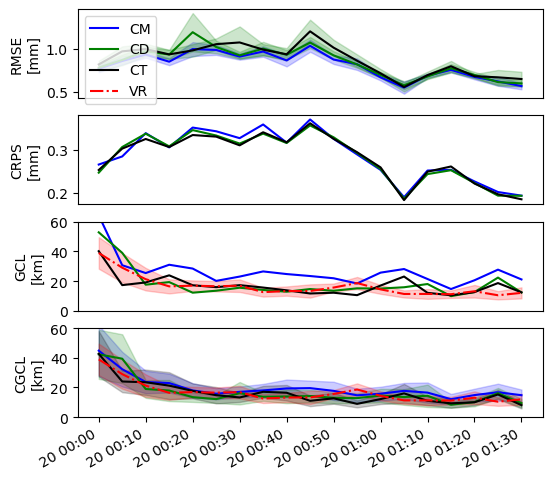

In [158]:
# subset = random, n_in_subsert = 18
fig, ax = plt.subplots(4,1, figsize=(6, 6))
time_list_plot = [time_list[i].values for i in range(len(time_list))]
# calculate RSME
RMSE_midpoint = []
RMSE_dereg = []
alpha = 0.5
time_i_start = 0

time_iterate = ds_cml.sel(time = slice(start, end)).time
        
# RMSE field
RMSE_midpoint_r = []
RMSE_dereg_r = []
RMSE_true_r = []
for i in range(np.array(copula_midpoint['field_conditioned']).shape[1]): 
    # midpoint
    SE = (np.array(copula_midpoint['field_conditioned'])[:, i, :, :]  - plot_true_values)**2
    RMSE = []
    for time_i in range(SE.shape[0]):
        RMSE.append(np.sqrt(SE[time_i].mean()))
    RMSE_midpoint_r.append(RMSE)
    
    SE = (np.array(copula_dereg['field_conditioned'])[:, i, :, :]  - plot_true_values)**2
    RMSE = []
    for time_i in range(SE.shape[0]):
        RMSE.append(np.sqrt(SE[time_i].mean()))  
    RMSE_dereg_r.append(RMSE)
    
    SE = (np.array(copula_true_midpoint['field_conditioned'])[:, i, :, :]  - plot_true_values)**2
    RMSE = []
    for time_i in range(SE.shape[0]):
        RMSE.append(np.sqrt(SE[time_i].mean()))  
    RMSE_true_r.append(RMSE)
    
RMSE_dereg_r = np.array(RMSE_dereg_r)
RMSE_midpoint_r = np.array(RMSE_midpoint_r)
RMSE_true_r = np.array(RMSE_true_r)

mean = RMSE_midpoint_r.mean(axis = 0)
std = RMSE_midpoint_r.std(axis = 0)
ax[0].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'blue', label = 'CM');
ax[0].fill_between(time_list_plot[time_i_start:],  mean[time_i_start:] - std[time_i_start:], mean[time_i_start:] + std[time_i_start:], color = 'blue', alpha=0.2)

mean = RMSE_dereg_r.mean(axis = 0)
std = RMSE_dereg_r.std(axis = 0)
ax[0].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'green', label = 'CD');
ax[0].fill_between(time_list_plot[time_i_start:], mean[time_i_start:] - std[time_i_start:], mean[time_i_start:] + std[time_i_start:], color = 'green', alpha=0.2)

mean = RMSE_true_r.mean(axis = 0)
std = RMSE_true_r.std(axis = 0)
ax[0].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'black', label = 'CT');
ax[0].fill_between(time_list_plot[time_i_start:], mean[time_i_start:] - std[time_i_start:], mean[time_i_start:] + std[time_i_start:], color = 'green', alpha=0.2)

ax[0].plot(np.nan, np.nan, '-.r', label = 'VR')

ax[0].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[0].set_ylabel('RMSE\n[mm]');
ax[0].legend(loc = 'upper left')


ax[1].plot(time_list_plot[time_i_start:], CRPS_midpoint_r[time_i_start:], color = 'blue', label = 'CM');
ax[1].plot(time_list_plot[time_i_start:], CRPS_dereg_r[time_i_start:], color = 'green', label = 'CD');
ax[1].plot(time_list_plot[time_i_start:], CRPS_true_r[time_i_start:], color = 'black', label = 'CT');

ax[1].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[1].set_ylabel('CRPS\n[mm]');

mean = np.array(copula_midpoint['gaussian_range_unconditioned']) # only one estimate for now
ax[2].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'blue', label = 'CM')
mean = np.array(copula_dereg['gaussian_range_unconditioned']) # only one estimate for now
ax[2].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'green', label = 'CD')
mean = np.array(copula_true_midpoint['gaussian_range_unconditioned']) # only one estimate for now
ax[2].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'black', label = 'CT')
           
mean = np.array(true_field['gaussian_range']).mean(axis = 1)
std = np.array(true_field['gaussian_range']).std(axis = 1)
ax[2].plot(time_list_plot[time_i_start:], mean[time_i_start:], '-.r', label = 'true field')
ax[2].fill_between(time_list_plot[time_i_start:], mean[time_i_start:] - std[time_i_start:], mean[time_i_start:] + std[time_i_start:], color = 'red', alpha=0.2)
ax[2].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
ax[2].set_ylabel('GCL\n[km]')




mean = np.nanmean(np.array(copula_midpoint['gaussian_range_conditioned']), axis = 1) 
std = np.nanstd(np.array(copula_midpoint['gaussian_range_conditioned']), axis = 1)
ax[3].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'blue', label = 'CM')
ax[3].fill_between(time_list_plot[time_i_start:],  mean[time_i_start:] - std[time_i_start:], 
                   mean[time_i_start:] + std[time_i_start:], color = 'blue', alpha=0.2)

mean = np.array(copula_dereg['gaussian_range_conditioned']).mean(axis = 1) # only one estimate for now
std = np.nanstd(np.array(copula_dereg['gaussian_range_conditioned']), axis = 1)
ax[3].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'green', label = 'CD')
ax[3].fill_between(time_list_plot[time_i_start:],  mean[time_i_start:] - std[time_i_start:], 
                   mean[time_i_start:] + std[time_i_start:],color = 'green', alpha=0.2)
           
           
mean = np.array(copula_true_midpoint['gaussian_range_conditioned']).mean(axis = 1) # only one estimate for now
std = np.nanstd(np.array(copula_true_midpoint['gaussian_range_conditioned']), axis = 1)
ax[3].plot(time_list_plot[time_i_start:], mean[time_i_start:], color = 'black', label = 'CT')
ax[3].fill_between(time_list_plot[time_i_start:],  mean[time_i_start:] - std[time_i_start:], 
                   mean[time_i_start:] + std[time_i_start:],color = 'black', alpha=0.2)
    

mean = np.array(true_field['gaussian_range']).mean(axis = 1)
std = np.array(true_field['gaussian_range']).std(axis = 1)
ax[3].plot(time_list_plot[time_i_start:], mean[time_i_start:], '-.r', label = 'true field')
ax[3].fill_between(time_list_plot[time_i_start:], mean[time_i_start:] - std[time_i_start:], 
                   mean[time_i_start:] + std[time_i_start:], color = 'red', alpha=0.2)

ax[3].set_ylabel('CGCL\n[km]')

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax[4].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#ax[0].set_ylim(0, 1.5)
ax[2].set_ylim(0, 60)
ax[3].set_ylim(0, 60)
fig.autofmt_xdate()
plt.savefig('/home/erlend/Downloads/result_RM_timesteps.png', format = 'png')